インポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [3]:
import lightgbm as lgb
import xgboost as xgb

from sklearn.linear_model import LogisticRegression

In [4]:
pd.options.display.max_rows=100
pd.options.display.max_columns=100

In [5]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample_submit = pd.read_csv('sample_submit.csv', index_col=0, header=None)

データの確認

In [6]:
print(train.shape, test.shape)

(8000, 9) (2000, 8)


In [7]:
display(train.head(), test.head())

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
gameId,,,,,,,,,
0,0,5,8,6,0,0,14536,17256,0
1,1,10,1,5,0,0,14536,17863,0
2,0,3,10,2,0,0,17409,17256,0
3,1,7,10,8,0,0,19558,18201,0
4,0,4,9,4,0,0,17409,17256,0


,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
gameId,,,,,,,,
9,0,7,6,6,0,0,16961,18201
15,0,6,6,6,2,1,18513,18021
18,1,6,4,3,0,0,13475,17256
23,0,5,4,7,0,0,17409,17256
31,0,10,8,9,0,0,18117,18472


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   blueFirstBlood       8000 non-null   int64
 1   blueKills            8000 non-null   int64
 2   blueDeaths           8000 non-null   int64
 3   blueAssists          8000 non-null   int64
 4   blueEliteMonsters    8000 non-null   int64
 5   blueDragons          8000 non-null   int64
 6   blueTotalGold        8000 non-null   int64
 7   blueTotalExperience  8000 non-null   int64
 8   blueWins             8000 non-null   int64
dtypes: int64(9)
memory usage: 625.0 KB


In [9]:
train.describe()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
count,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.513000,6.029750,5.92350,5.881875,0.538625,0.358125,17154.067750,17983.514000,0.491750
std,0.499862,2.623876,2.64892,3.189897,0.629728,0.479479,1820.796171,772.348402,0.499963
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,13475.000000,16650.000000,0.000000
25%,0.000000,4.000000,4.00000,3.000000,0.000000,0.000000,16544.000000,17256.000000,0.000000
50%,1.000000,6.000000,6.00000,6.000000,0.000000,0.000000,17409.000000,18021.000000,0.000000
75%,1.000000,8.000000,8.00000,8.000000,1.000000,1.000000,18274.000000,18472.000000,1.000000
max,1.000000,14.000000,14.00000,17.000000,2.000000,1.000000,20619.000000,20101.000000,1.000000


In [10]:
train.columns

Index(['blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueTotalGold',
       'blueTotalExperience', 'blueWins'],
      dtype='object')

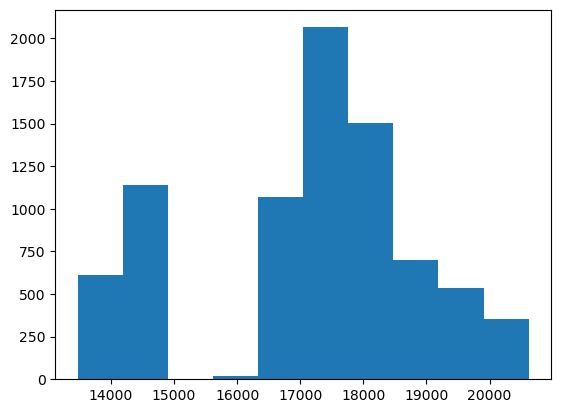

In [11]:
plt.hist(train['blueTotalGold']);

In [12]:
train['blueTotalGold'].value_counts()

blueTotalGold
17409    1881
14536    1142
18274    1047
16961     811
18513     698
19558     513
18117     459
13519     320
20619     319
13475     294
16544     257
17381     165
20038      32
19407      23
16146      20
17450      10
17440       9
Name: count, dtype: int64

In [13]:
train.corrwith(train['blueWins']).sort_values(ascending=False)

blueWins               1.000000
blueKills              0.337541
blueTotalExperience    0.328167
blueAssists            0.311647
blueEliteMonsters      0.272810
blueDragons            0.251957
blueFirstBlood         0.226536
blueTotalGold          0.040489
blueDeaths            -0.237224
dtype: float64

特徴量の選定

In [14]:
selected_cols =['blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
                'blueEliteMonsters', 'blueDragons', 'blueTotalGold',
                'blueTotalExperience']
train_X = train[selected_cols]
train_y = train['blueWins']
test_X =test[selected_cols]

バリデーション＆モデリング

lightgbm

In [123]:
scores1 = []
lgb_probas = []

kf = KFold(n_splits=4, shuffle=True, random_state=71)

for tr_idx, va_idx in kf.split(train_X, train_y):
    tr_X, va_X = train_X.iloc[tr_idx], train_X.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    lgb_train = lgb.Dataset(tr_X, tr_y)
    lgb_eval = lgb.Dataset(va_X, va_y)
    
    params = {'objective': 'binary', 'seed': 71, 'verbose': 0, 'metric': 'accuracy', 'learning_rate': 0.07}
    num_round = 90
    
    model_1 = lgb.train(params, lgb_train, num_boost_round=num_round, valid_names=['train', 'valid'], valid_sets=[lgb_train, lgb_eval])
    
    pred1_proba = model_1.predict(va_X)
    pred1 = np.where(pred1_proba < 0.5, 0, 1).astype(int)

    score1 = accuracy_score(va_y, pred1)
    print(score1)

    lgb_proba = model_1.predict(test_X)

    scores1.append(score1)
    lgb_probas.append(lgb_proba)

    df_pred1=pd.DataFrame(pred1)
    print(df_pred1.value_counts())


print('total: ')
print(np.mean(scores1))
print(df_pred1.value_counts()[0].mean())
print(df_pred1.value_counts()[1].mean())

lgb_probas = pd.DataFrame(lgb_probas).T
lgb_proba = lgb_probas.mean(axis=1)
lgb_pred = lgb_proba.apply(lambda x: 0 if x < 0.5 else 1).astype(int)
print('lgb: ')
print(lgb_pred.value_counts()[0].mean())
print(lgb_pred.value_counts()[1].mean())

0.7975
0    1048
1     952
Name: count, dtype: int64
0.794
1    1014
0     986
Name: count, dtype: int64
0.797
0    1035
1     965
Name: count, dtype: int64
0.7765
1    1017
0     983
Name: count, dtype: int64
total: 
0.79125
983.0
1017.0
lgb: 
975.0
1025.0


xgbClassifiier

In [124]:
scores2 = []
xgb_probas = []

kf = KFold(n_splits=4, shuffle=True, random_state=71)
for (tr_idx, va_idx) in kf.split(train_X, train_y):
    tr_X, va_X = train_X.iloc[tr_idx], train_X.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    model_2 = xgb.XGBClassifier(n_estimators=450, eta=0.3, max_depth=3, colsample_bytree=0.8, subsample=0.8)
    model_2.fit(tr_X, tr_y)
    
    pred2_proba = model_2.predict_proba(va_X)
    pred2 = np.argmax(pred2_proba, axis=1).astype(int)
    
    score2 = accuracy_score(va_y, pred2)
    print(score2)

    df_pred2 =pd.DataFrame(pred2)
    print(df_pred2.value_counts())

    xgb_proba = model_2.predict_proba(test_X)

    scores2.append(score2)
    xgb_probas.append(xgb_proba)

print('total: ')
print(np.mean(scores2))
print(df_pred2.value_counts()[0].mean())
print(df_pred2.value_counts()[1].mean())

xgb_probas = np.delete(xgb_probas, 0, axis=2)
xgb_probas = pd.DataFrame(xgb_probas.reshape(4, 2000)).T
xgb_proba = xgb_probas.mean(axis=1)
xgb_pred = xgb_proba.apply(lambda x: 0 if x < 0.5 else 1).astype(int)
print('xgb: ')
print(xgb_pred.value_counts()[0].mean())
print(xgb_pred.value_counts()[1].mean())

0.793
0    1043
1     957
Name: count, dtype: int64
0.795
1    1020
0     980
Name: count, dtype: int64
0.7925
0    1018
1     982
Name: count, dtype: int64
0.785
1    1002
0     998
Name: count, dtype: int64
total: 
0.791375
998.0
1002.0
xgb: 
984.0
1016.0


スタッキング

In [125]:
meta_train_X = np.column_stack((pred1, pred2))
meta_train_X = pd.DataFrame(meta_train_X)
meta_train_y = va_y.copy()

meta_scores = []

kf = KFold(n_splits=4, shuffle=True, random_state=71)
for meta_tr_idx, meta_va_idx in kf.split(meta_train_X, meta_train_y):
    meta_tr_X, meta_va_X = meta_train_X.iloc[meta_tr_idx], meta_train_X.iloc[meta_va_idx]
    meta_tr_y, meta_va_y = meta_train_y.iloc[meta_tr_idx], meta_train_y.iloc[meta_va_idx]
    meta_model = LogisticRegression()
    meta_model.fit(meta_tr_X, meta_tr_y)

    meta_pred_proba = meta_model.predict_proba(meta_va_X)
    meta_pred = np.argmax(meta_pred_proba, axis=1).astype(int)

    meta_score = accuracy_score(meta_va_y, meta_pred)
    print(meta_score)
    df_meta_pred = pd.DataFrame(meta_pred)
    print(df_meta_pred.value_counts())

    meta_scores.append(meta_score)

print('total: ')
print(np.mean(meta_scores))
print(df_meta_pred.value_counts()[0].mean())
print(df_meta_pred.value_counts()[1].mean())

0.794
0    260
1    240
Name: count, dtype: int64
0.806
0    258
1    242
Name: count, dtype: int64
0.772
0    254
1    246
Name: count, dtype: int64
0.76
1    254
0    246
Name: count, dtype: int64
total: 
0.7829999999999999
246.0
254.0


最終予測

In [127]:
level1_preds = np.column_stack((lgb_pred, xgb_pred))
level1_preds = pd.DataFrame(level1_preds)

pred_proba = meta_model.predict_proba(level1_preds)
pred = np.argmax(pred_proba, axis=1).astype(int)

df_pred =  pd.DataFrame(pred)
print(df_pred.value_counts())

1    1016
0     984
Name: count, dtype: int64


In [122]:
submit = sample_submit.copy()
submit[1] = pred
submit.to_csv('submit.csv', header=None)